This kernel is forked from Andrew's Pytorch Kernel https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools

I have done a couple things to speed things up and allow for larger models. The first one is that I <b>resized the dataset before hand so that we do not need to do this repetitively for each epoch</b>. This takes our epoch time down from ~23 minutes down to ~7 minutes using the same resnet 50 unet architecture. You can do whatever you like with this additional time, train more models, more epochs, larger backbones, etc. 

The second thing I have done is <b>add in nvidia apex so we can do mixed precision training</b>. This roughly halves memory usage on the GPU and allows us to fit larger models or larger batch sizes. 

This has allowed me to train the larger se_resnext101_32x4d backbone in a shorter amount of time while also getting a better score.  

In [1]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-vz9k9tje
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-vz9k9tje
     |████████████████████████████████| 61kB 2.4MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.0.3-cp36-none-any.whl size=30054 sha256=f075424ad2664efcfcc67b631913d0014d34a4f1799014ca1503c5e9992f224a
  Stored in directory: /tmp/pip-ephem-wheel-cache-wqqiknxv/wheels/79/3f/09/1587a252e0314d26ad242d6d2e165622ab95c95e5cfe4b942c
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=49902f15a8461f92d707286205120d5fe41b60023099033af4e21435d49e5bae
  Stored in directory: /tmp/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.4.0-cp36-none-any.whl size=11149 sha256=f89ce86187c9c04536fd3b7e3b02

## Importing and parameters

In [2]:
import os, gc, time, json, copy
import pickle, random, itertools, collections
from tqdm import tqdm, tqdm_notebook
from functools import partial

import numpy as np
import pandas as pd
from PIL import Image
import cv2

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import albumentations as albu
from albumentations import pytorch as AT
import segmentation_models_pytorch as smp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 2019

label_classes = ["Fish", "Flower", "Gravel", "Sugar"]

path = '../input/understanding_cloud_organization'
img_paths = '../input/understanding-clouds-resized'
model0_path = '../input/cloud-im-small/'
model1_path = '../input/cld-rn50-unet-1/'
model2_path = '../input/cld-rn50-unet-2/'
model3_path = '../input/cld-rn50-unet-3/'
model4_path = '../input/cld-rn50-unet-4/'
model_paths = [model0_path, model1_path, model2_path, model3_path, model4_path]

n_splits = 5
which_fold = 4  # should be int in [0, n_splits-1]

batch_size = 16

## Helper functions and classes

In [4]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

def seed_torch(seed=SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def get_img(x, folder: str='train_images_525/train_images_525'):
    """
    Return image based on image name and folder.
    """
    data_folder = f"{img_paths}/{folder}"
    image_path = os.path.join(data_folder, x)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    """
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

def make_mask(image_name: str='img.jpg', shape: tuple=(350, 525)):
    "Create mask (ndarray, values between 0-1) based on image name and shape."
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)
    for classidx, classid in enumerate(label_classes):
        mask = cv2.imread("../input/understanding-clouds-resized/train_masks_525/train_masks_525/" + classid + image_name)
        if mask is None:
            continue
        if mask[:,:,0].shape != (350,525):
            mask = cv2.resize(mask, (525,350))
        masks[:, :, classidx] = mask[:,:,0]
    masks = masks / 255
    return masks

def mask2rle(img):
    """
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    """
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def visualize(image, mask, original_image=None, original_mask=None):
    """
    Plot images and masks.
    
    Input
    - image: ndarray image loaded from cv2
    - mask: ndarray output from make_mask
    - original ones: If given, show them all
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 5, figsize=(24, 24))

        ax[0].imshow(image)
        for i in range(4):
            ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].set_title(f'Mask {class_dict[i]}', fontsize=fontsize)
    else:
        f, ax = plt.subplots(2, 5, figsize=(24, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
                
        for i in range(4):
            ax[0, i + 1].imshow(original_mask[:, :, i])
            ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)
        
        ax[1, 0].imshow(image)
        ax[1, 0].set_title('Transformed image', fontsize=fontsize)        
        
        for i in range(4):
            ax[1, i + 1].imshow(mask[:, :, i])
            ax[1, i + 1].set_title(f'Transformed mask {class_dict[i]}', fontsize=fontsize)
            
            
def visualize_with_raw(image, mask, original_image=None, original_mask=None, raw_image=None, raw_mak=None):
    """
    Plot images and masks.
    
    Input
    - image: ndarray image loaded from cv2
    - mask: ndarray output from make_mask
    - original ones / raw ones: If given, show them all
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}

    f, ax = plt.subplots(3, 5, figsize=(24, 12))

    ax[0, 0].imshow(original_image)
    ax[0, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[0, i + 1].imshow(original_mask[:, :, i])
        ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)

    ax[1, 0].imshow(raw_image)
    ax[1, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[1, i + 1].imshow(raw_mak[:, :, i])
        ax[1, i + 1].set_title(f'Raw predicted mask {class_dict[i]}', fontsize=fontsize)
        
    ax[2, 0].imshow(image)
    ax[2, 0].set_title('Transformed image', fontsize=fontsize)

    for i in range(4):
        ax[2, i + 1].imshow(mask[:, :, i])
        ax[2, i + 1].set_title(f'Predicted mask with processing {class_dict[i]}', fontsize=fontsize)
            
            
def plot_with_augmentation(image, mask, augment):
    """
    Plot images, masks and augmentation results.
    
    Input
    - image: ndarray image loaded from cv2
    - mask: ndarray output from make_mask
    - augment: transformation from albumentations
    """
    augmented = augment(image=image, mask=mask)
    image_flipped = augmented['image']
    mask_flipped = augmented['mask']
    visualize(image_flipped, mask_flipped, original_image=image, original_mask=mask)


def post_process(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    
    Input
    - probability: predicted probability mask, ndarray (350, 525)
    - threshold: value to binarize probability mask
    - min_size: ??
    """
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((350, 525), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(256, 384)
#         albu.Resize(320, 640)
#         albu.Resize(448, 448)
    ]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


def compute_dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)

    intersection = np.logical_and(img1, img2)

    return 2. * intersection.sum() / (img1.sum() + img2.sum())

## Data overview

Let's have a look at the data first.
We have folders with train and test images, file with train image ids and masks and sample submission.

In [5]:
train = pd.read_csv(f'{path}/train.csv')
sub = pd.read_csv(f'{path}/sample_submission.csv')

In [6]:
n_train = len(os.listdir(f'{img_paths}/train_images_525/train_images_525'))
n_test = len(os.listdir(f'{img_paths}/test_images_525/test_images_525'))
print(f'There are {n_train} images in train dataset')
print(f'There are {n_test} images in test dataset')

There are 5546 images in train dataset
There are 3698 images in test dataset


## Preparing data for modelling

At first, let's create a list of unique image ids and the count of masks for images. This will allow us to make a stratified split based on this count.

In [7]:
def train_val_split(id_mask_count, n_splits=None, which_fold=None):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    cv_indices = [(tr_idx, val_idx) for tr_idx, val_idx in kf.split(id_mask_count['img_id'], id_mask_count['count'])]
    if which_fold is not None:
        return cv_indices[which_fold]
    return cv_indices

In [8]:
id_mask_count = (train.loc[~train['EncodedPixels'].isnull(), 'Image_Label']
                    .apply(lambda x: x.split('_')[0])
                    .value_counts()
                    .reset_index()
                    .rename(columns={'index': 'img_id', 'Image_Label': 'count'}))

trn_idx, val_idx = train_val_split(id_mask_count, n_splits, which_fold)
train_ids, valid_ids = id_mask_count['img_id'].values[trn_idx], id_mask_count['img_id'].values[val_idx]
test_ids = sub['Image_Label'].apply(lambda x: x.split('_')[0]).drop_duplicates().values

In [9]:
# val_ids = [id_mask_count['img_id'].values[train_val_split(id_mask_count, n_splits, i)[1]]
#            for i in range(n_splits)]

# with open('val_ids.pkl', 'wb') as f:
#     pickle.dump(val_ids, f)
    
# with open('test_ids.pkl', 'wb') as f:
#     pickle.dump(test_ids, f)

In [10]:
valid_ids[:15]

array(['45855f6.jpg', '476b209.jpg', 'f1e8c3f.jpg', '607635f.jpg',
       'cc768f0.jpg', 'cd807f8.jpg', '3a1d51d.jpg', 'efe1652.jpg',
       'ff38d0a.jpg', '2f1f439.jpg', '46c4c72.jpg', '562f80a.jpg',
       '7639280.jpg', 'eba901f.jpg', '766616a.jpg'], dtype=object)

In [11]:
len(train_ids), len(valid_ids)

(4438, 1108)

In [12]:
id_mask_count

,img_id,count
0,fd02ab6.jpg,4
1,5526689.jpg,4
2,1c25e19.jpg,4
3,b01c91f.jpg,4
4,92865e2.jpg,4
...,...,...
5541,0fe3fd9.jpg,1
5542,ac1e24e.jpg,1
5543,0799206.jpg,1
5544,a8f84e0.jpg,1


In [13]:
id_mask_count['count'].value_counts()

2    2372
3    1560
1    1348
4     266
Name: count, dtype: int64

There are a lot of empty masks. In fact only 266 images have all four masks. It is important to remember this.

## Setting up data loader, model, solver

In [14]:
class CloudDataset(Dataset):
    def __init__(self, dataset_type: str='train', img_ids: np.array=None,
                 transforms=albu.Compose([albu.HorizontalFlip(), AT.ToTensor()]),
                 preprocessing=None, label_smooth=0):
        self.dataset_type = dataset_type
        if dataset_type != 'test':
            self.data_folder = f"{img_paths}/train_images_525/train_images_525"
        else:
            self.data_folder = f"{img_paths}/test_images_525/test_images_525"
        self.img_ids = img_ids
        self.transforms = transforms
        self.preprocessing = preprocessing
        self.label_smooth = label_smooth

    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        mask = make_mask(image_name)
        img = cv2.imread(os.path.join(self.data_folder, image_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        if self.label_smooth > 0:
            mask = np.where(mask==1, 1-label_smooth, label_smooth).astype('float32')
        if self.preprocessing:
            preprocessed = self.preprocessing(image=img, mask=mask)
            img = preprocessed['image']
            mask = preprocessed['mask']
        return img, mask

    def __len__(self):
        return len(self.img_ids)

In [15]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = None
ACTIVATION = None

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER)

model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=4, 
    activation=ACTIVATION
)
model = model.to(device)
model.load_state_dict(torch.load(model_paths[which_fold]+'best_model_optim.pt')['model'])

<All keys matched successfully>

In [16]:
print(str(torch.cuda.memory_allocated(device)/1e6 ) + 'M')
print(str(torch.cuda.memory_cached(device)/1e6 ) + 'M')
torch.cuda.empty_cache()

131.664384M
555.74528M


In [17]:
valid_dataset = CloudDataset(dataset_type='valid', img_ids=valid_ids,
                             transforms=get_validation_augmentation(),
                             preprocessing=get_preprocessing(preprocessing_fn))

valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

/opt/conda/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2567: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


## Model inference

In [18]:
def get_preds(loader, model, dataset_type='test'):
    """
    Inference for testset.

    :param loader: DataLoader for testing data
    :param model: model
    :param dataset_type: dataset type

    :return: ndarray predictions
    """
    assert dataset_type in ('val', 'test')
    model.eval()  # eval mode disables dropout

    if dataset_type=='val':
        label_masks = []
    predictions = []
    with torch.no_grad():
        # Batches
        for images, masks in tqdm_notebook(loader):
            if dataset_type=='val': 
                for m in masks.view(-1, 256, 384).numpy():
#                 for m in masks.view(-1, 320, 640).numpy():
#                 for m in masks.view(-1, 448, 448).numpy():
                    m = cv2.resize(m, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
                    label_masks.append(m)

            # Move to default device
            images = images.to(device)  # (N, 3, 320, 640)

            # Forward prop.
            pred_scores = model(images)  # (N, 4, 320, 640)
            pred_scores = pred_scores.view(-1, 256, 384)
#             pred_scores = pred_scores.view(-1, 320, 640)  # (N*4, 320, 640)
#             pred_scores = pred_scores.view(-1, 448, 448)  # (N*4, 320, 640)

            for m in torch.sigmoid(pred_scores).cpu().numpy():
                m = cv2.resize(m, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
                predictions.append(m)
    torch.cuda.empty_cache()

    if dataset_type=='val':
        return predictions, label_masks
    return predictions

In [19]:
class Rot90(object):
    """rotate batch of images by 90 degrees k times"""
    def __init__(self, k=1):
        self.k = k
    def transform(self, x):
        return torch.rot90(x, self.k, (2, 3))
    def inverse(self, x):
        return torch.rot90(x, -self.k, (2, 3))

class Hflip(object):
    """flip batch of images horizontally"""
    def transform(self, x):
        return x.flip(3)
    def inverse(self, x):
        return x.flip(3)

class Vflip(object):
    """flip batch of images vertically"""
    def transform(self, x):
        return x.flip(2)
    def inverse(self, x):
        return x.flip(2)

def TTA(loader, model, dataset_type='test', beta=0.4):
    """
    Inference for testset with test-time augmentation (TTA).

    :param loader: DataLoader for testing data
    :param model: model
    :param dataset_type: dataset type
    :param beta: ratio of prediction from original dataset in final results

    :return: ndarray predictions
    """
    assert dataset_type in ('val', 'test')
    model.eval()  # eval mode disables dropout
    tsfms = [Vflip(), Hflip(), Rot90(k=1), Rot90(k=2), Rot90(k=3)]

    if dataset_type=='val':
        label_masks = []
    predictions = []
    with torch.no_grad():
        # Batches
        for images, masks in tqdm_notebook(loader):
            if dataset_type=='val':
                for m in masks.view(-1, 256, 384).numpy():
#                 for m in masks.view(-1, 320, 640).numpy():
#                 for m in masks.view(-1, 448, 448).numpy():
                    m = cv2.resize(m, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
                    label_masks.append(m)
            
            # Move to default device
            images = images.to(device)  # (N, 3, 320, 640)
            
            # Forward prop.
            pred_scores = beta * model(images)  # (N, 4, 320, 640)
            
            # TTA
            for tsfm in tsfms:
                pred_scores += (1-beta) * tsfm.inverse(model(tsfm.transform(images))) / len(tsfms)
            
            # Resize to required size
            pred_scores = pred_scores.view(-1, 256, 384)
#             pred_scores = pred_scores.view(-1, 320, 640)  # (N*4, 320, 640)
#             pred_scores = pred_scores.view(-1, 448, 448)  # (N*4, 320, 640)
            for m in torch.sigmoid(pred_scores).cpu().numpy():
                m = cv2.resize(m, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
                predictions.append(m)
    torch.cuda.empty_cache()

    if dataset_type=='val':
        return predictions, label_masks
    return predictions

### Determine threshold from validation

In [20]:
# predictions, valid_masks = get_preds(valid_loader, model, dataset_type='val') # list, list
predictions, valid_masks = TTA(valid_loader, model, dataset_type='val') # list, list

print(str(torch.cuda.memory_allocated(device)/1e6 ) + 'M')
print(str(torch.cuda.memory_cached(device)/1e6 ) + 'M')
torch.cuda.empty_cache()


131.664384M
155.189248M


In [21]:
attempts_dfs = []
class_params = []

for cls_id, clss in enumerate(label_classes):
    print(f"class_id {cls_id}: {clss}")
    attempts = []
    for thresh in range(20, 70, 5):   # threshold to decide 0/1
        thresh /= 100
        for ms in [10000, 15000, 20000, 22500, 25000, 27500]:   # minimum size for qualified mask
            dices = []
            for i in range(cls_id, len(predictions), 4):
                prob_mask = predictions[i]
                pred, num_segs = post_process(prob_mask, thresh, ms)
                if num_segs > 0:
                    dices.append(compute_dice(pred, valid_masks[i]))
                elif pred.sum()==0 and valid_masks[i].sum()==0:
                    dices.append(1)
                else:
                    dices.append(0)

            attempts.append((thresh, ms, np.mean(dices)))

    attempts_df = pd.DataFrame(attempts, columns=['threshold', 'size', 'dice'])
    attempts_df = attempts_df.sort_values('dice', ascending=False)
    attempts_dfs.append(attempts_df)
    print(attempts_df.head())
    print()
    
    best_threshold = attempts_df['threshold'].values[0]
    best_size = attempts_df['size'].values[0]
    class_params.append((best_threshold, best_size))

class_id 0: Fish
    threshold   size      dice
15       0.30  22500  0.665879
10       0.25  25000  0.664885
16       0.30  25000  0.664543
14       0.30  20000  0.664314
31       0.45  15000  0.663755

class_id 1: Flower
    threshold   size      dice
26       0.40  20000  0.804138
38       0.50  20000  0.802958
21       0.35  22500  0.802931
55       0.65  15000  0.802875
32       0.45  20000  0.802014

class_id 2: Gravel
    threshold   size      dice
37       0.50  15000  0.669234
32       0.45  20000  0.666540
43       0.55  15000  0.666254
14       0.30  20000  0.666227
15       0.30  22500  0.665188

class_id 3: Sugar
    threshold   size      dice
18       0.35  10000  0.627693
1        0.20  15000  0.625383
7        0.25  15000  0.625298
13       0.30  15000  0.625176
12       0.30  10000  0.624200



In [22]:
print(class_params)

[(0.3, 22500), (0.4, 20000), (0.5, 15000), (0.35, 10000)]


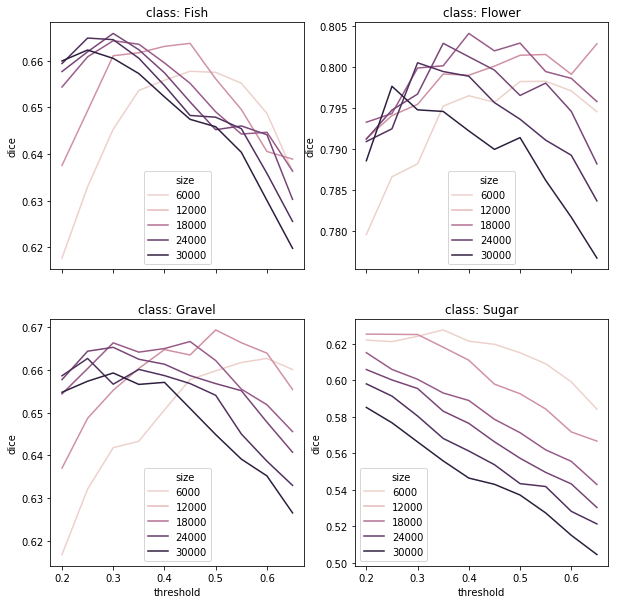

In [23]:
f, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True)
for i, df in enumerate(attempts_dfs):
    ax = axes[i//2, i%2]
    sns.lineplot(x='threshold', y='dice', hue='size', data=df, ax=ax)
    ax.set_title(f'class: {label_classes[i]}')

### Prediction from validation set

In [24]:
valid_dices = []
for i, prob_mask in enumerate(predictions):
    pred, num_pred = post_process(prob_mask, *class_params[i%4])
    if num_pred > 0:
        valid_dices.append(compute_dice(pred, valid_masks[i]))
    elif pred.sum()==0 and valid_masks[i].sum()==0:
        valid_dices.append(1)
    else:
        valid_dices.append(0)

print(f'validation dice: {np.mean(valid_dices)}')

validation dice: 0.6917358797307772


In [25]:
valid_dices = []
image_id = 0
for i, prob_mask in enumerate(predictions):
    pred, num_pred = post_process(prob_mask, *class_params[image_id%4])
    if num_pred > 0:
        valid_dices.append(compute_dice(pred, valid_masks[i]))
#     elif pred.sum()==0 and valid_masks[i].sum()==0:
#         valid_dices.append(1)
    image_id += 1

print(f'validation dice: {np.mean(valid_dices)}')

validation dice: 0.6221650588944576


In [26]:
class_params = [(0.45, 22500), (0.5, 22500), (0.45, 22500), (0.4, 22500)]
valid_dices = []
for i, prob_mask in enumerate(predictions):
    pred, num_pred = post_process(prob_mask, *class_params[i%4])
    if num_pred > 0:
        valid_dices.append(compute_dice(pred, valid_masks[i]))
    elif pred.sum()==0 and valid_masks[i].sum()==0:
        valid_dices.append(1)
    else:
        valid_dices.append(0)

print(f'validation dice: {np.mean(valid_dices)}')

validation dice: 0.6707136580108065


In [27]:
class_params = [(0.5, 35000), (0.5, 35000), (0.5, 35000), (0.5, 35000)]
valid_dices = []
for i, prob_mask in enumerate(predictions):
    pred, num_pred = post_process(prob_mask, *class_params[i%4])
    if num_pred > 0:
        valid_dices.append(compute_dice(pred, valid_masks[i]))
    elif pred.sum()==0 and valid_masks[i].sum()==0:
        valid_dices.append(1)
    else:
        valid_dices.append(0)

print(f'validation dice: {np.mean(valid_dices)}')

validation dice: 0.6307030025212529
